In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from IPython.display import clear_output
!pip install tf_explain
clear_output()

In [3]:
# common
import os
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi

# Data
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Data Viz
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization

# Callbacks
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM

# Metrics
from keras.metrics import MeanIoU

In [4]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]

    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))

    for i,image in enumerate(image_paths):
        img = load_image(image,SIZE)
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img

    return images

In [5]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

In [6]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

In [7]:
SIZE = 256

In [8]:
root_path = '/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/'
classes = sorted(os.listdir(root_path))
classes

['benign', 'malignant', 'normal']

In [9]:
print(root_path + classes[0] + "/*_mask.png")
single_mask_paths = sorted([sorted(glob(root_path + name + "/*_mask.png")) for name in classes])
double_mask_paths = sorted([sorted(glob(root_path + name + "/*mask_1.png")) for name in classes])

/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/*_mask.png


In [10]:
image_paths = []
mask_paths = []
print(single_mask_paths)
for class_path in single_mask_paths:
    for path in class_path:
        img_path = path.replace('_mask','')
        image_paths.append(img_path)
        mask_paths.append(path)

[['/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (1)_mask.png', '/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (10)_mask.png', '/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', '/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (101)_mask.png', '/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (102)_mask.png', '/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (103)_mask.png', '/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (104)_mask.png', '/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (105)_mask.png', '/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (106)_mask.png', '/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (107)_mask.png', '/content/drive/MyDrive/Breastc

In [11]:
print(image_paths)


['/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (1).png', '/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (10).png', '/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (100).png', '/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (101).png', '/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (102).png', '/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (103).png', '/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (104).png', '/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (105).png', '/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (106).png', '/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (107).png', '/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (1

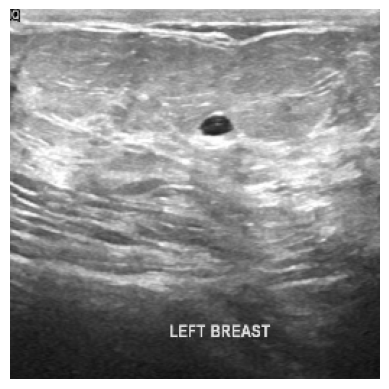

In [12]:
show_image(load_image(image_paths[0], SIZE))

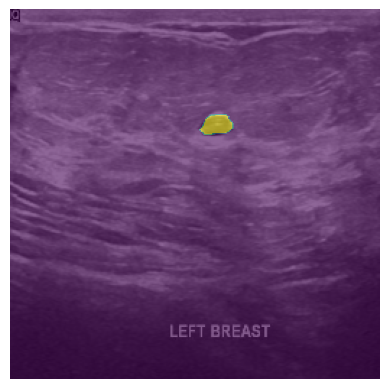

In [13]:
show_mask(load_image(image_paths[0], SIZE), load_image(mask_paths[0], SIZE)[:,:,0], alpha=0.6)

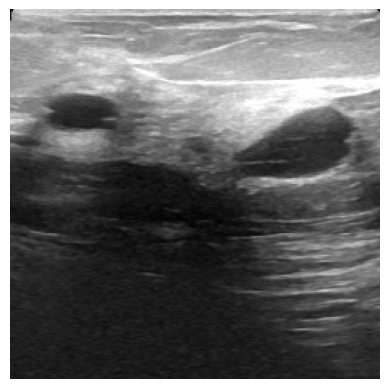

In [14]:
show_image(load_image('/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))

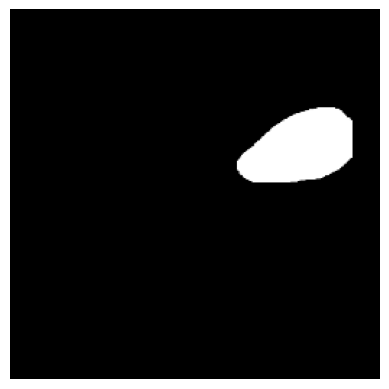

In [15]:
show_image(load_image('/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', SIZE))

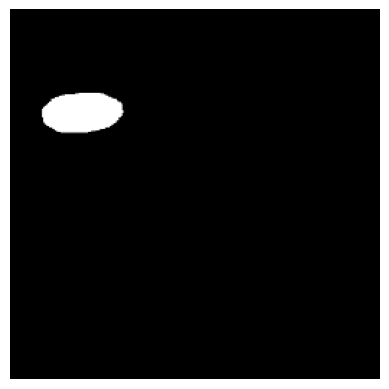

In [16]:
show_image(load_image('/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', SIZE))

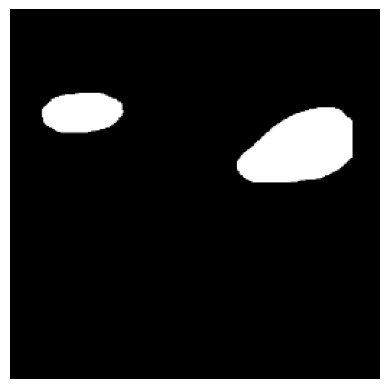

In [17]:
img = np.zeros((1,SIZE,SIZE,3))
mask1 = load_image('/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', SIZE)
mask2 = load_image('/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', SIZE)

img = img + mask1 + mask2
img = img[0,:,:,0]
show_image(img, cmap='gray')

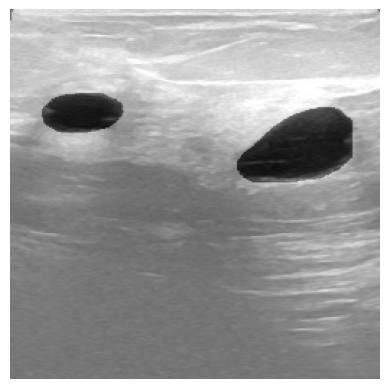

In [18]:
show_image(load_image('/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, cmap='binary', alpha=0.4)
plt.axis('off')
plt.show()

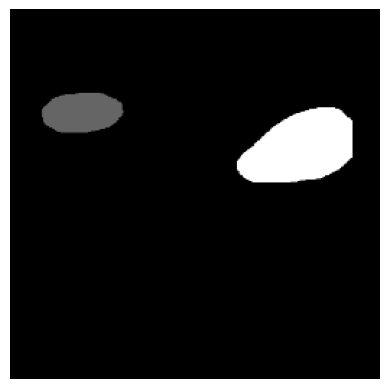

In [19]:
show_image(load_image('/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', SIZE))
plt.imshow(img, cmap='gray', alpha=0.4)
plt.axis('off')
plt.show()

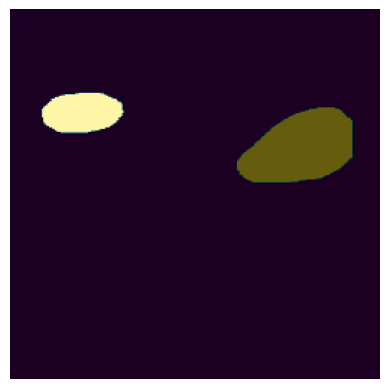

In [20]:
show_image(load_image('/content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', SIZE))
plt.imshow(img, alpha=0.4)
plt.axis('off')
plt.show()

In [21]:
images = load_images(image_paths, SIZE)
masks = load_images(mask_paths, SIZE, mask=True)

780


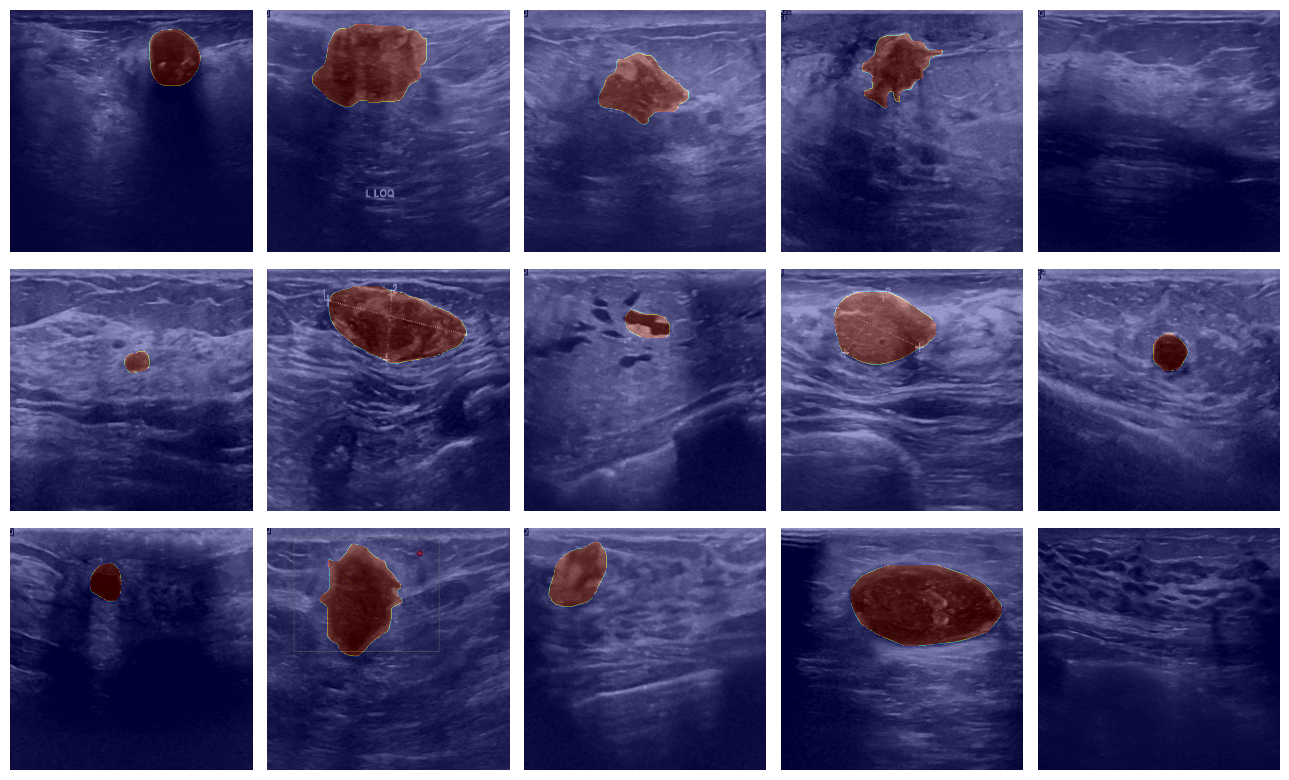

In [22]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='jet')
print(len(images))
plt.tight_layout()
plt.show()

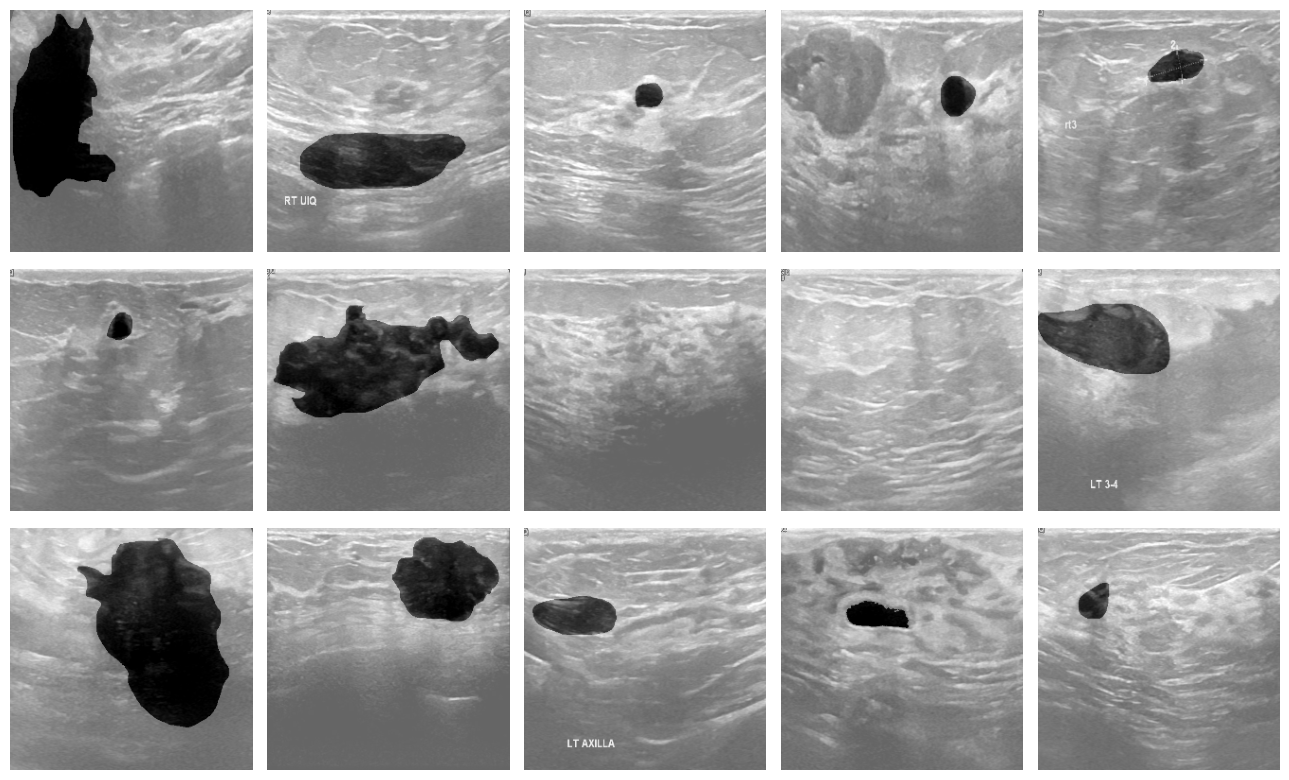

In [23]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='binary')
plt.tight_layout()
plt.show()

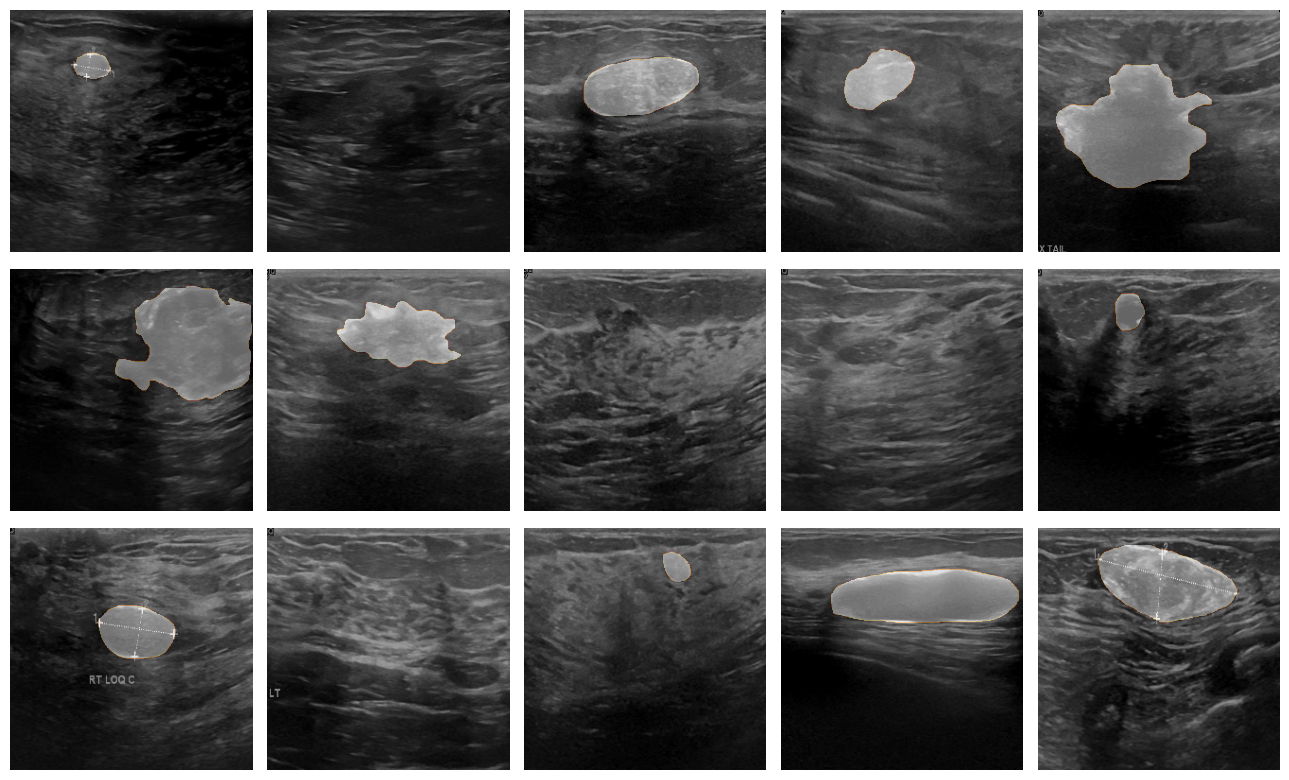

In [24]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='afmhot')
plt.tight_layout()
plt.show()

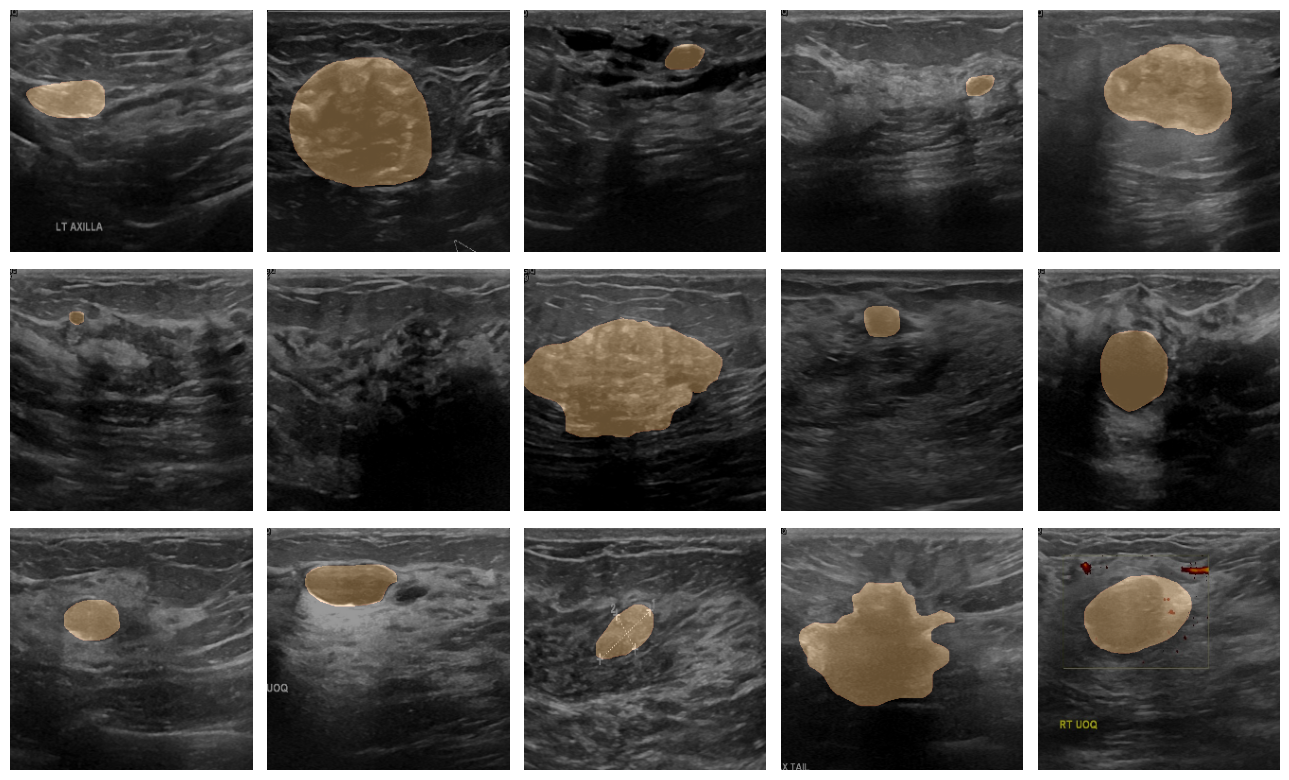

In [25]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='copper')
plt.tight_layout()
plt.show()

In [26]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

In [27]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

In [28]:
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

In [33]:
class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
        id = np.random.randint(200)
        exp = GradCAM()
        image = images[id]
        mask = masks[id]
        pred_mask = self.model.predict(image[np.newaxis,...])

        plt.figure(figsize=(10,5))

        plt.subplot(1,3,1)
        plt.title("Original Mask")
        show_mask(image, mask, cmap='copper')

        plt.subplot(1,3,2)
        plt.title("Predicted Mask")
        show_mask(image, pred_mask, cmap='copper')

        plt.subplot(1,3,3)
        show_image(pred_mask[0,:,:,0],title="GradCAM")

        plt.tight_layout()
        plt.show()


In [34]:
# Inputs
input_layer = Input(shape=images.shape[-3:])

# Encoder
c1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(input_layer)
p1 = MaxPool2D()(c1)

c2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(p1)
p2 = MaxPool2D()(c2)

c3 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(p2)
p3 = MaxPool2D()(c3)

c4 = Conv2D(256, kernel_size=3, activation='relu', padding='same')(p3)
p4 = MaxPool2D()(c4)

# Bottleneck
encoding = Conv2D(512, kernel_size=3, activation='relu', padding='same')(p4)

# Decoder
u1 = UpSampling2D()(encoding)
d1 = Conv2D(256, kernel_size=3, activation='relu', padding='same')(u1)

u2 = UpSampling2D()(d1)
d2 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(u2)

u3 = UpSampling2D()(d2)
d3 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(u3)

u4 = UpSampling2D()(d3)
d4 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(u4)

# Output
output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

# Model
model = Model(
    inputs=[input_layer],
    outputs=[output_layer]
)

def dice_coefficient(y_true, y_pred):
    smooth = 1e-5
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# Compile
model.compile(
    loss=dice_loss,
    optimizer='adam',
    metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')]
)


# Callbacks
cb = [
    # EarlyStopping(patience=3, restore_best_weight=True), # With Segmentation I trust on eyes rather than on metrics
    ModelCheckpoint("AttentionCustomUNet.h5", save_best_only=True),
    ShowProgress()
]

Epoch 1/10
1/1 [==============================] - 0s 111ms/step


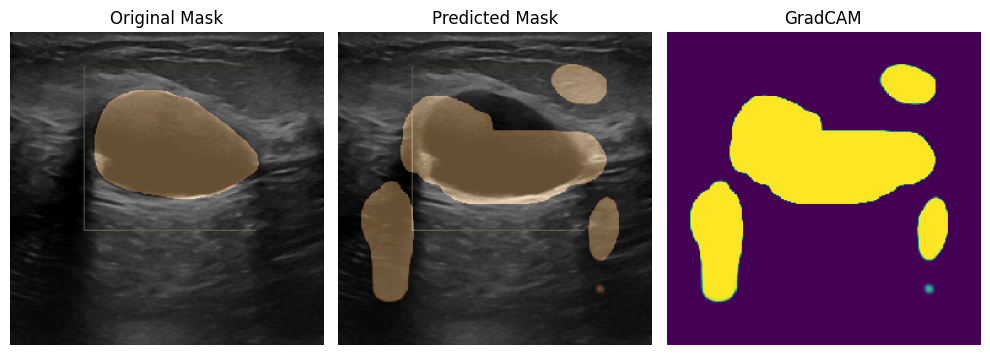

97/97 [==============================] - 14s 97ms/step - loss: 0.7267 - accuracy: 0.6174 - IoU: 0.5055 - val_loss: 0.9311 - val_accuracy: 0.8800 - val_IoU: 0.4988
Epoch 2/10
1/1 [==============================] - 0s 17ms/step


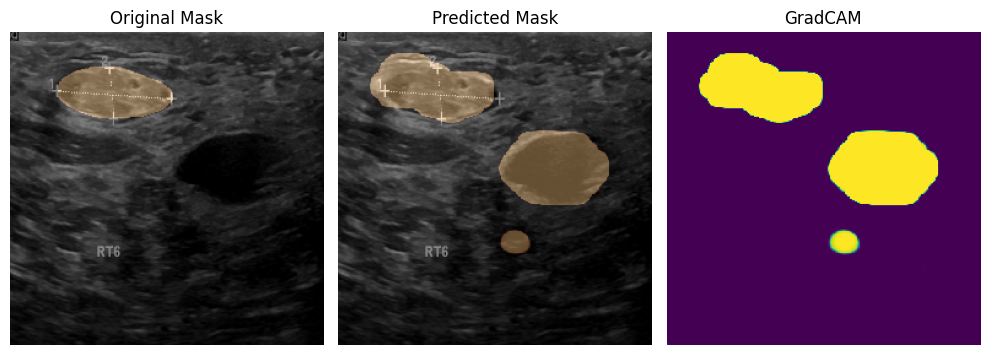

97/97 [==============================] - 8s 85ms/step - loss: 0.5876 - accuracy: 0.8570 - IoU: 0.5697 - val_loss: 0.9419 - val_accuracy: 0.9584 - val_IoU: 0.5340
Epoch 3/10
1/1 [==============================] - 0s 26ms/step


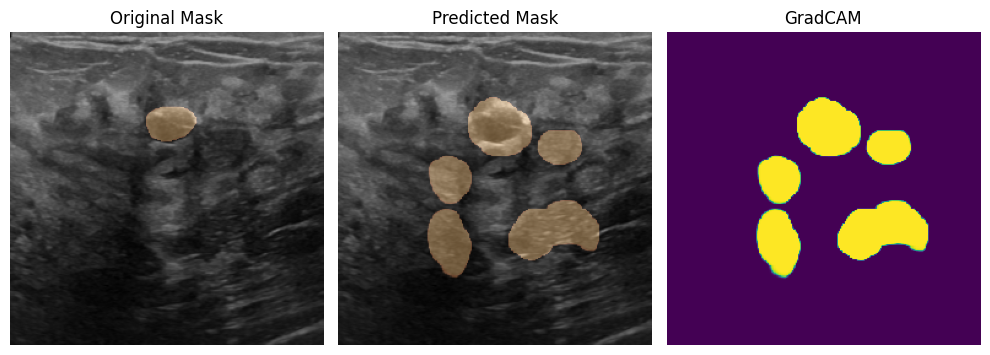

97/97 [==============================] - 9s 90ms/step - loss: 0.5535 - accuracy: 0.8878 - IoU: 0.5945 - val_loss: 0.9189 - val_accuracy: 0.9439 - val_IoU: 0.5467
Epoch 4/10
1/1 [==============================] - 0s 18ms/step


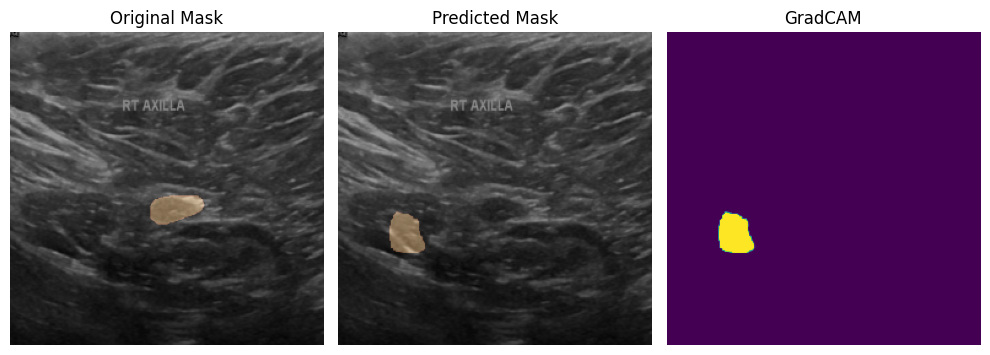

97/97 [==============================] - 8s 85ms/step - loss: 0.5004 - accuracy: 0.9079 - IoU: 0.6239 - val_loss: 0.9223 - val_accuracy: 0.9782 - val_IoU: 0.6059
Epoch 5/10
1/1 [==============================] - 0s 17ms/step


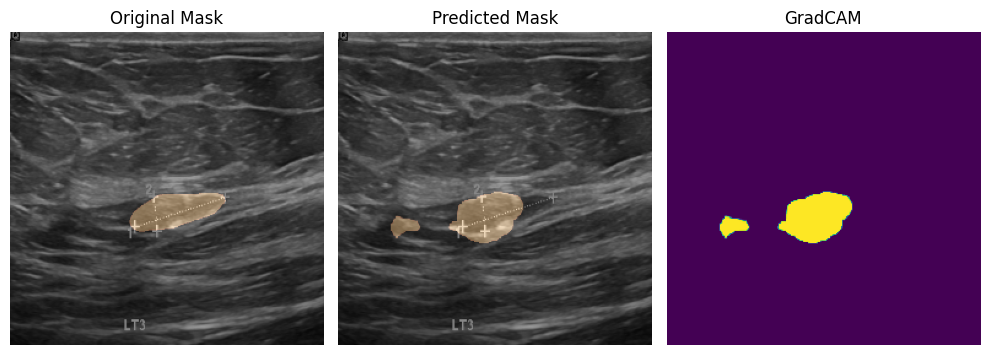

97/97 [==============================] - 8s 87ms/step - loss: 0.4739 - accuracy: 0.9128 - IoU: 0.6399 - val_loss: 0.9166 - val_accuracy: 0.9745 - val_IoU: 0.6052
Epoch 6/10
1/1 [==============================] - 0s 27ms/step


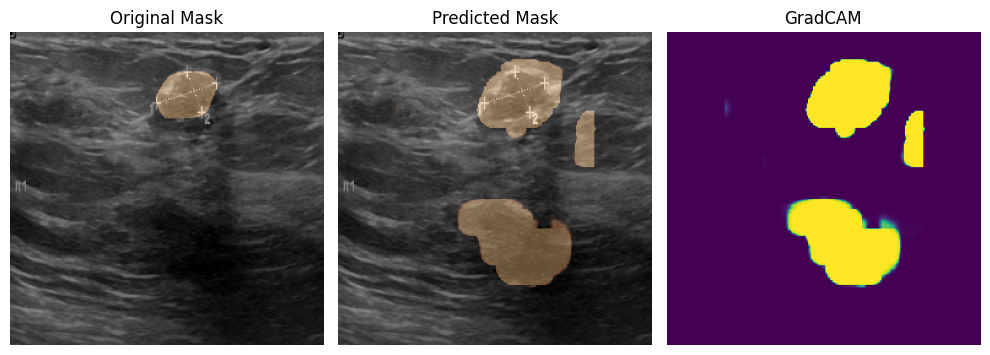

97/97 [==============================] - 9s 91ms/step - loss: 0.4600 - accuracy: 0.9168 - IoU: 0.6468 - val_loss: 0.9040 - val_accuracy: 0.9514 - val_IoU: 0.6020
Epoch 7/10
1/1 [==============================] - 0s 17ms/step


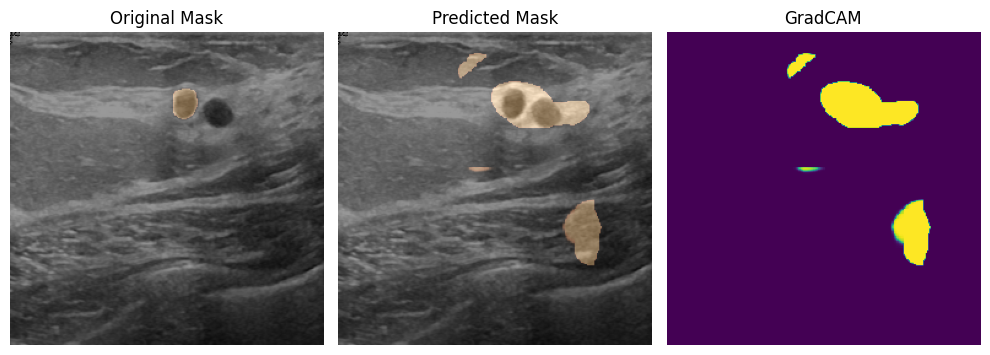

97/97 [==============================] - 8s 87ms/step - loss: 0.4568 - accuracy: 0.9192 - IoU: 0.6513 - val_loss: 0.9062 - val_accuracy: 0.9189 - val_IoU: 0.5399
Epoch 8/10
1/1 [==============================] - 0s 17ms/step


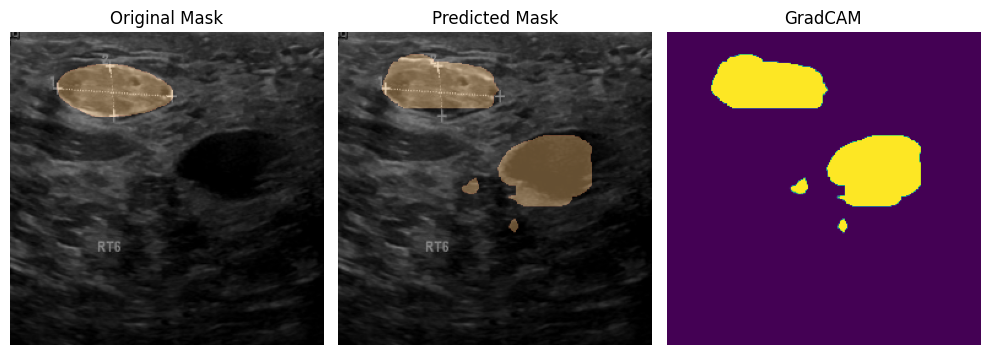

97/97 [==============================] - 9s 90ms/step - loss: 0.4336 - accuracy: 0.9223 - IoU: 0.6634 - val_loss: 0.9040 - val_accuracy: 0.9761 - val_IoU: 0.6444
Epoch 9/10
 4/97 [>.............................] - ETA: 7s - loss: 0.3391 - accuracy: 0.9372 - IoU: 0.7096

1/1 [==============================] - 0s 19ms/step


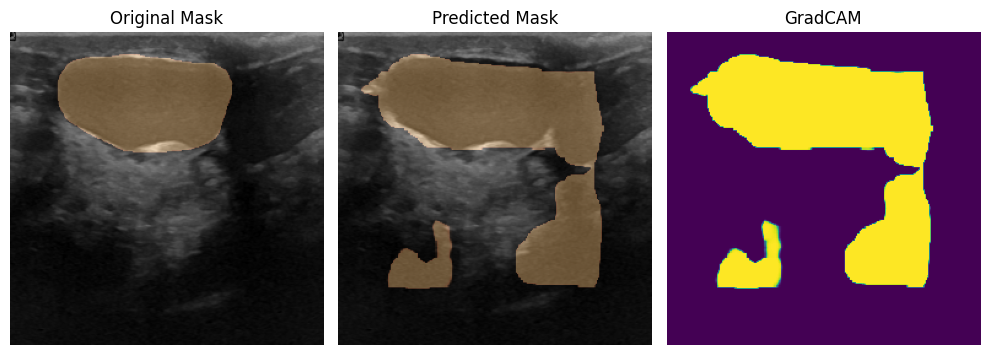

97/97 [==============================] - 1s 13ms/step - loss: 0.3391 - accuracy: 0.9372 - IoU: 0.7096 - val_loss: 0.9090 - val_accuracy: 0.9534 - val_IoU: 0.5951


In [35]:
# Config Training
BATCH_SIZE = 8
SPE = len(images)//BATCH_SIZE

# Training
results = model.fit(
    images, masks,
    validation_split=0.2,
    epochs=10, # 15 will be enough for a good Model for better model go with 20+
    steps_per_epoch=SPE,
    batch_size=BATCH_SIZE,
    callbacks=cb
)

In [36]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()

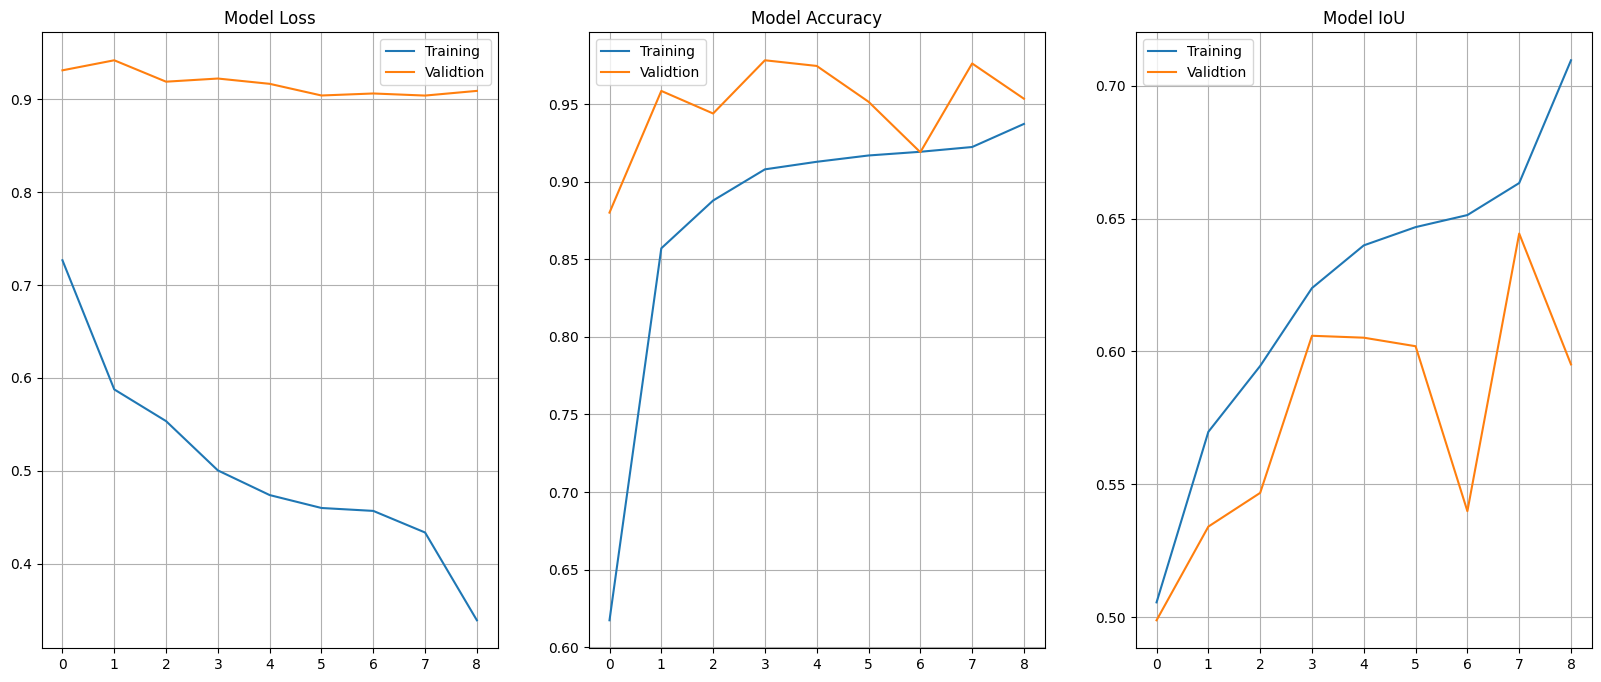

In [37]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.title("Model Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.title("Model Accuracy")
plt.plot(accuracy, label="Training")
plt.plot(val_accuracy, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.title("Model IoU")
plt.plot(iou, label="Training")
plt.plot(val_iou, label="Validtion")
plt.legend()
plt.grid()

plt.show()

1/1 [==============================] - 0s 18ms/step


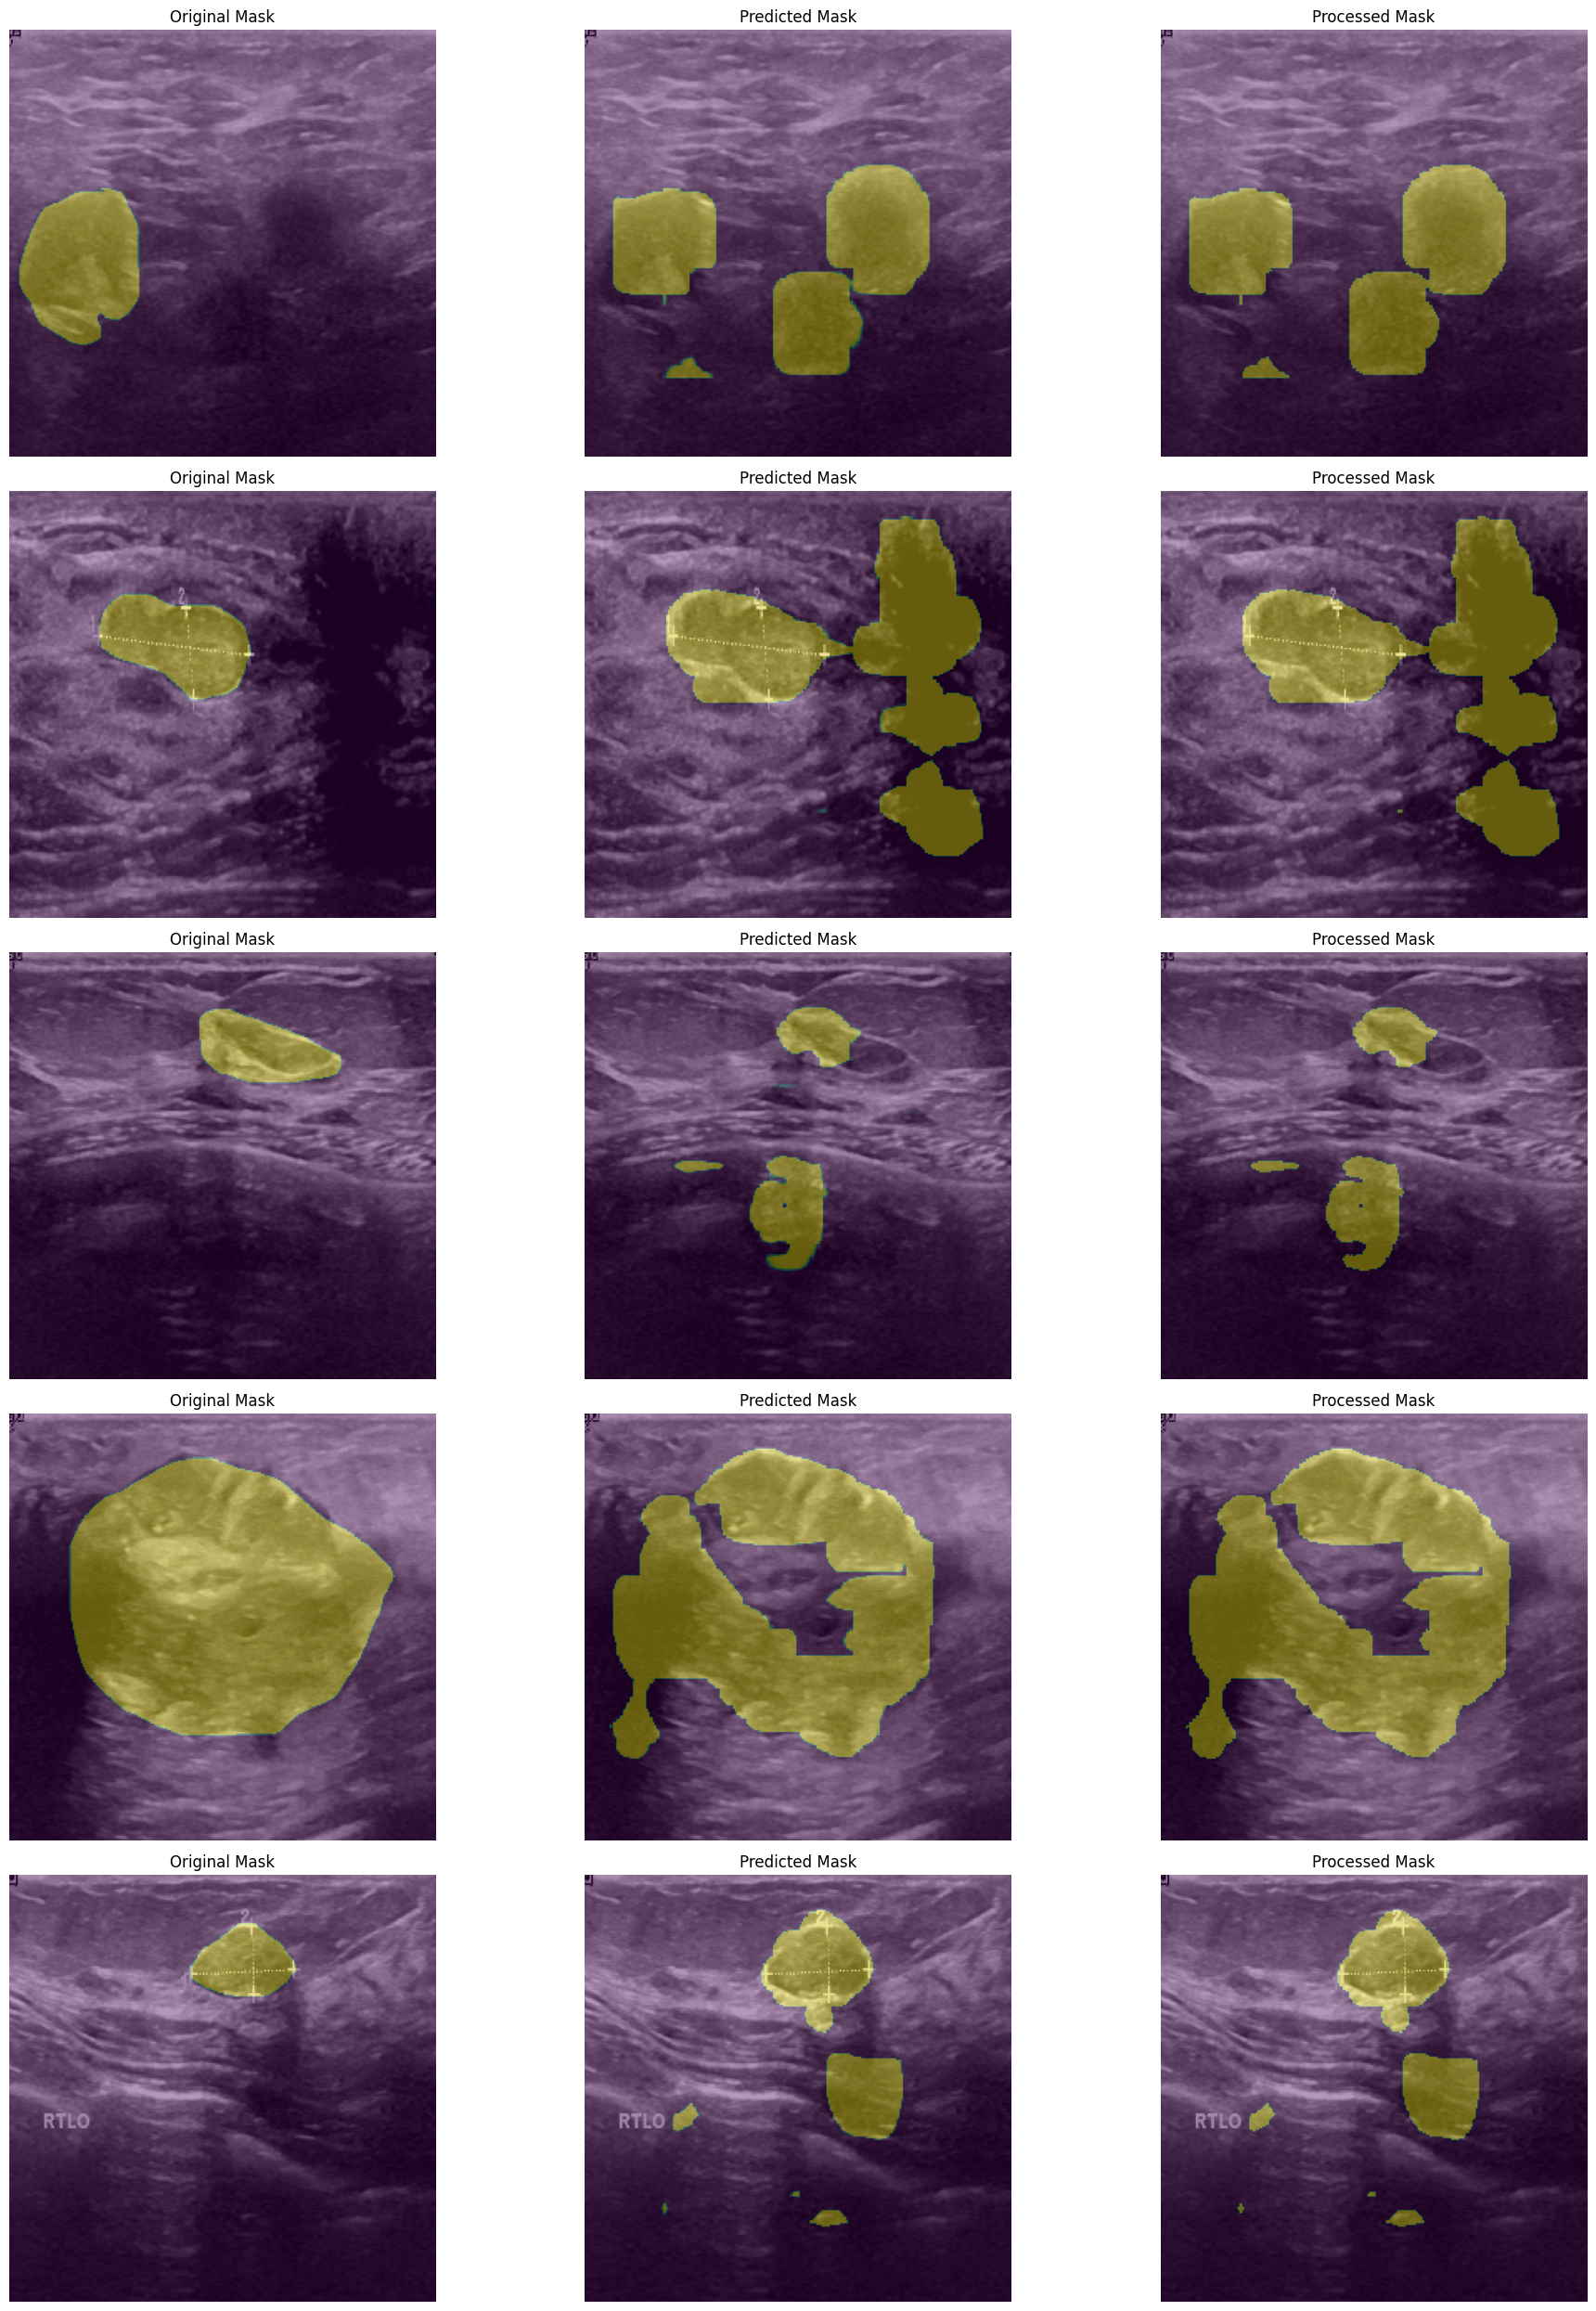

In [38]:
plt.figure(figsize=(20,25))
n=0
for i in range(1,(5*3)+1):
    plt.subplot(5,3,i)
    if n==0:
        id = np.random.randint(len(images))
        image = images[id]
        mask = masks[id]
        pred_mask = model.predict(image[np.newaxis,...])

        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        pred_mask = (pred_mask>0.5).astype('float')
        plt.title("Processed Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()

In [39]:
def save_network(model, file_path):
    model.save(file_path)

# Assuming 'model' is your trained model
save_path = 'ainain_unetwithoutskipconnection_model.pth'
save_network(model, save_path)


In [40]:
def load_network(file_path):
    return tf.keras.models.load_model(file_path)


In [41]:
def test(net, model, test_set_x, test_set_y):
    predictions = model.predict(test_set_x)
    return predictions


In [42]:
def preprocess_image(image_path):
    # Load and preprocess the image
    image = load_image(image_path, SIZE)  # Assuming load_image is a function that loads and preprocesses the image
    return image

def predict_mask(model, image):
    # Make prediction using the model
    mask = model.predict(image[np.newaxis, ...])
    return mask

def runtime_testing(model):
    # Take input image from the user
    image_path = input("Enter the path to the image: ")

    # Preprocess the image
    image = preprocess_image(image_path)

    # Predict the mask
    mask = predict_mask(model, image)

    return mask

# Assuming 'model' is your trained UNet model
mask_prediction = runtime_testing(model)


Enter the path to the image: /content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (100).png
1/1 [==============================] - 0s 20ms/step


Enter the path to the image: /content/drive/MyDrive/Breastcancer_dataset/Dataset_BUSI_with_GT/benign/benign (100).png
1/1 [==============================] - 0s 21ms/step
Input Image:


Predicted Mask:


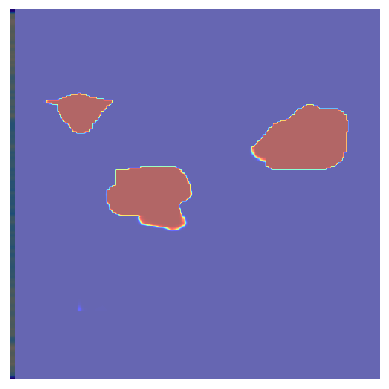

In [43]:
def runtime_testing(model):
    # Take input image from the user
    image_path = input("Enter the path to the image: ")

    # Preprocess the image
    image = preprocess_image(image_path)

    # Predict the mask
    mask_prediction = predict_mask(model, image)

    # Display the input image
    print("Input Image:")
    show_image(image[0], cmap='gray')  # Assuming input image is grayscale
    plt.show()

    # Display the predicted mask
    print("Predicted Mask:")
    show_mask(image[0], mask_prediction[0, :, :, 0], cmap='jet', alpha=0.6)  # Assuming predicted mask is grayscale
    plt.show()

    return mask_prediction

# Assuming 'model' is your trained UNet model
mask_prediction = runtime_testing(model)


In [54]:
def tsne_representation(model, images, labels, batch_size=32):
    # Find the last convolutional layer before the bottleneck
    last_conv_layer_name = 'conv2d_18'  # Example name, replace with the actual name of the last conv layer

    # Get the encoder's last layer output
    encoder_output = Model(inputs=model.input, outputs=model.get_layer(last_conv_layer_name).output)

    # Initialize an empty array to store the TSNE representations
    tsne_encoded_images = []

    # Process images in batches
    for i in range(0, len(images), batch_size):
        batch_images = images[i:i+batch_size]

        # Get the encoder output for the batch of images
        encoded_images = encoder_output.predict(batch_images)

        # Reshape the encoded images into 2D array
        encoded_images_2d = encoded_images.reshape(encoded_images.shape[0], -1)

        # Use TSNE to reduce the dimensionality of the encoded images to 2D
        tsne = TSNE(n_components=2, random_state=42)
        tsne_batch_encoded_images = tsne.fit_transform(encoded_images_2d)

        # Append the batch of TSNE representations to the overall list
        tsne_encoded_images.extend(tsne_batch_encoded_images)

    # Convert the list of TSNE representations to a numpy array
    tsne_encoded_images = np.array(tsne_encoded_images)

    # Plot the TSNE representation
    plt.figure(figsize=(10, 10))
    plt.scatter(tsne_encoded_images[:, 0], tsne_encoded_images[:, 1], c=labels, cmap='viridis')
    plt.colorbar()
    plt.title('TSNE Representation of Encoded Images')
    plt.show()

# Assuming 'images' is your dataset and 'labels' are the corresponding labels for each image
tsne_representation(model, images, labels)


Exception ignored in: <function _xla_gc_callback at 0x7cd352bf6b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


1/1 [==============================] - 0s 137ms/step


NameError: name 'TSNE' is not defined